In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


In [2]:
DATA_PATH = r"D:\Coding\VanetUAV\data\processed\cicids_10pct_stratified.csv"
PCA_FEATURE_PATH = r"D:\Coding\VanetUAV\data\processed\pca_feature_importance.csv"

RANDOM_STATE = 42


In [3]:
df = pd.read_csv(DATA_PATH)

df["label_bin"] = (df["Label"] != "BENIGN").astype(int)

df.shape


(283074, 84)

In [4]:
train_files = [
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
]

test_files = [
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
]

train_idx = df["source_file"].isin(train_files)
test_idx  = df["source_file"].isin(test_files)

df_train = df[train_idx]
df_test  = df[test_idx]

df_train.shape, df_test.shape


((212883, 84), (70191, 84))

In [5]:
pca_importance = pd.read_csv(PCA_FEATURE_PATH, index_col=0)

TOP_K = 25   # matches ~90% variance
pca_features = pca_importance.sort_values("importance", ascending=False).head(TOP_K).index.tolist()

pca_features


['Idle Std',
 'Active Min',
 'FIN Flag Count',
 'Flow IAT Min',
 'Init_Win_bytes_backward',
 'Active Std',
 'SYN Flag Count',
 'Fwd PSH Flags',
 'Down/Up Ratio',
 'PSH Flag Count',
 'Active Mean',
 'Bwd IAT Std',
 'Fwd Packets/s',
 'Flow Packets/s',
 'Bwd Packets/s',
 'Min Packet Length',
 'Active Max',
 'Bwd IAT Total',
 'URG Flag Count',
 'Fwd Packet Length Min',
 'Init_Win_bytes_forward',
 'Flow Bytes/s',
 'Bwd IAT Min',
 'Bwd IAT Max',
 'Bwd Packet Length Min']

In [6]:
META_COLS = [
    "Label",
    "label_bin",
    "label_binary",
    "source_file",
    "day",
    "attack_group"
]

X_train = df_train[pca_features]
X_test  = df_test[pca_features]

y_train = df_train["label_bin"]
y_test  = df_test["label_bin"]


In [7]:
X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna()
X_test  = X_test.replace([np.inf, -np.inf], np.nan).dropna()

y_train = y_train.loc[X_train.index]
y_test  = y_test.loc[X_test.index]

X_train.shape, X_test.shape


((212656, 25), (70152, 25))

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression (PCA features)")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))


d:\Coding\VanetUAV\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression (PCA features)
              precision    recall  f1-score   support

           0       0.60      0.96      0.74     41243
           1       0.61      0.08      0.15     28909

    accuracy                           0.60     70152
   macro avg       0.60      0.52      0.44     70152
weighted avg       0.60      0.60      0.50     70152

AUC: 0.7732536659394951


In [9]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest (PCA features)")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest (PCA features)
              precision    recall  f1-score   support

           0       0.59      1.00      0.74     41243
           1       0.71      0.00      0.00     28909

    accuracy                           0.59     70152
   macro avg       0.65      0.50      0.37     70152
weighted avg       0.64      0.59      0.44     70152

AUC: 0.7855200129026577


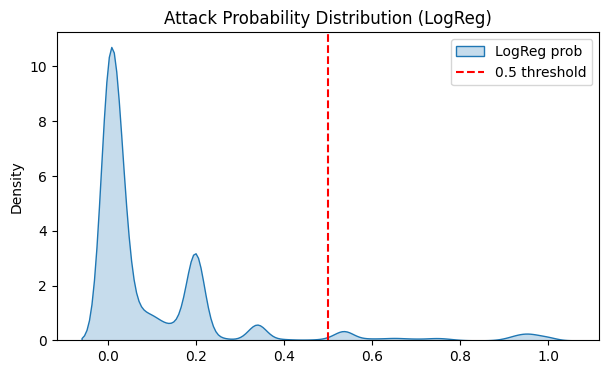

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.kdeplot(y_prob, label="LogReg prob", fill=True)
plt.axvline(0.5, color="red", linestyle="--", label="0.5 threshold")
plt.legend()
plt.title("Attack Probability Distribution (LogReg)")
plt.show()


In [11]:
def eval_threshold(y_true, y_prob, thresh):
    y_pred = (y_prob >= thresh).astype(int)
    print(f"\nThreshold = {thresh}")
    print(classification_report(y_true, y_pred))
    print("AUC:", roc_auc_score(y_true, y_prob))


In [12]:
for t in [0.1, 0.2, 0.3, 0.4]:
    eval_threshold(y_test, y_prob, t)



Threshold = 0.1
              precision    recall  f1-score   support

           0       0.67      0.79      0.72     41243
           1       0.59      0.44      0.51     28909

    accuracy                           0.65     70152
   macro avg       0.63      0.62      0.62     70152
weighted avg       0.64      0.65      0.63     70152

AUC: 0.7732536659394951

Threshold = 0.2
              precision    recall  f1-score   support

           0       0.62      0.93      0.75     41243
           1       0.68      0.19      0.30     28909

    accuracy                           0.63     70152
   macro avg       0.65      0.56      0.53     70152
weighted avg       0.65      0.63      0.56     70152

AUC: 0.7732536659394951

Threshold = 0.3
              precision    recall  f1-score   support

           0       0.62      0.95      0.75     41243
           1       0.69      0.15      0.25     28909

    accuracy                           0.62     70152
   macro avg       0.65      

In [13]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    class_weight="balanced",
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

y_prob_rf = rf.predict_proba(X_test)[:, 1]

for t in [0.2, 0.3, 0.4]:
    eval_threshold(y_test, y_prob_rf, t)



Threshold = 0.2
              precision    recall  f1-score   support

           0       0.61      0.98      0.75     41243
           1       0.79      0.10      0.18     28909

    accuracy                           0.62     70152
   macro avg       0.70      0.54      0.47     70152
weighted avg       0.68      0.62      0.52     70152

AUC: 0.7672701084644576

Threshold = 0.3
              precision    recall  f1-score   support

           0       0.60      0.99      0.75     41243
           1       0.86      0.08      0.14     28909

    accuracy                           0.61     70152
   macro avg       0.73      0.53      0.45     70152
weighted avg       0.71      0.61      0.50     70152

AUC: 0.7672701084644576

Threshold = 0.4
              precision    recall  f1-score   support

           0       0.59      1.00      0.74     41243
           1       0.25      0.00      0.00     28909

    accuracy                           0.59     70152
   macro avg       0.42      

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_leaf=10,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

y_prob_rf = rf.predict_proba(X_test)[:, 1]


In [15]:
for t in [0.05, 0.1, 0.15, 0.2]:
    eval_threshold(y_test, y_prob_rf, t)



Threshold = 0.05
              precision    recall  f1-score   support

           0       0.76      0.91      0.83     41243
           1       0.82      0.59      0.69     28909

    accuracy                           0.78     70152
   macro avg       0.79      0.75      0.76     70152
weighted avg       0.79      0.78      0.77     70152

AUC: 0.8316499411860192

Threshold = 0.1
              precision    recall  f1-score   support

           0       0.64      0.95      0.76     41243
           1       0.76      0.23      0.35     28909

    accuracy                           0.65     70152
   macro avg       0.70      0.59      0.56     70152
weighted avg       0.69      0.65      0.59     70152

AUC: 0.8316499411860192

Threshold = 0.15
              precision    recall  f1-score   support

           0       0.62      0.96      0.75     41243
           1       0.75      0.15      0.25     28909

    accuracy                           0.63     70152
   macro avg       0.68    

In [17]:
baseline_results = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Features": "PCA (25)",
        "Threshold": 0.10,
        "Attack Precision": 0.59,
        "Attack Recall": 0.44,
        "Attack F1": 0.51,
        "Accuracy": 0.65,
        "AUC": 0.77
    },
    {
        "Model": "Random Forest",
        "Features": "PCA (25)",
        "Threshold": 0.05,
        "Attack Precision": 0.82,
        "Attack Recall": 0.59,
        "Attack F1": 0.69,
        "Accuracy": 0.78,
        "AUC": 0.83
    }
])

baseline_results


,Model,Features,Threshold,Attack Precision,Attack Recall,Attack F1,Accuracy,AUC
0,Logistic Regression,PCA (25),0.10,0.59,0.44,0.51,0.65,0.77
1,Random Forest,PCA (25),0.05,0.82,0.59,0.69,0.78,0.83


In [18]:
baseline_results.to_csv(
    "../data/processed/baseline_pca_results.csv",
    index=False
)
